In [1]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



First we load the ADHD200 data
-------------------------------



In [2]:
import numpy as np
data=np.load('/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/All_Data.npy')
Y=np.load('/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/All_Labels.npy')

In [3]:
mask_img ='/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/ADHD200_mask_152_4mm.nii.gz'

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="/storage/nilearn_cache", 
                     memory_level=2)
fmri_masked = masker.fit()

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/storage/nilearn_cache'", use "location='/storage/nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Here we apply CanICA on the data
---------------------------------



In [4]:
from nilearn.decomposition import DictLearning

dict_learning = DictLearning(n_components=40, memory_level=2,
                             verbose=1,
                             random_state=0,
                             n_epochs=1)
dict_learning.masker_=masker


dict_learning._init_dict(data)
dict_learning._init_loadings(data)
dict_init = dict_learning.loadings_init_

n_iter = ((50000 - 1) // 20 + 1) * 1
print(n_iter)

from sklearn.decomposition import dict_learning_online
components, diction =dict_learning_online(data.T,n_components=40, 
                                            alpha=10,shuffle=1,dict_init=dict_init,
                                            batch_size=20,method="cd",n_iter=n_iter,
                                            verbose=1)


# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.



/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s finished
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(s

2500
[dict_learning] ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
components=components.T  

import numpy as np
S = np.sqrt(np.sum(components ** 2, axis=1))
S[S == 0] = 1
components /= S[:, np.newaxis]

# Flip signs in each composant so that positive part is l1 larger
# than negative part. Empirically this yield more positive looking maps
# than with setting the max to be positive.
for component in components:
    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1
                
components_img=masker.inverse_transform(components)

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


To visualize we plot the outline of all components on one figure
-----------------------------------------------------------------



/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


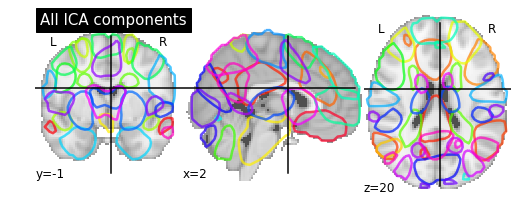

In [6]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(components_img, title='All ICA components')

Finally, we plot the map for each ICA component separately
-----------------------------------------------------------



/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


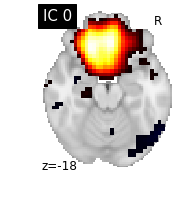

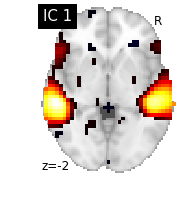

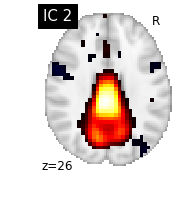

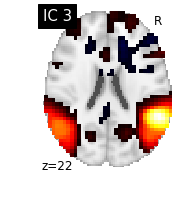

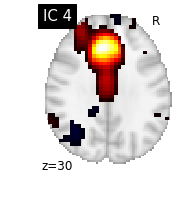

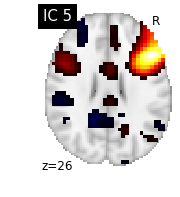

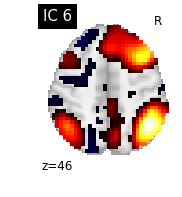

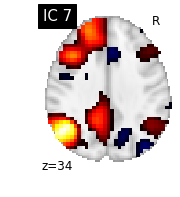

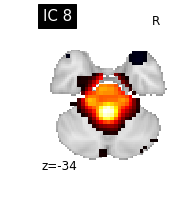

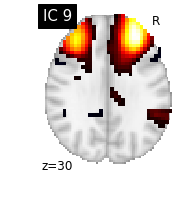

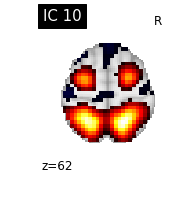

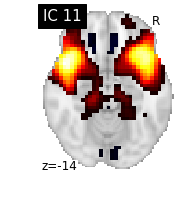

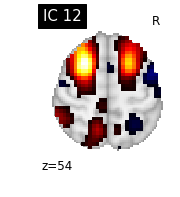

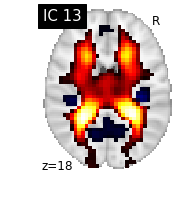

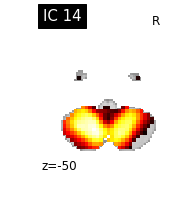

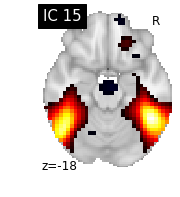

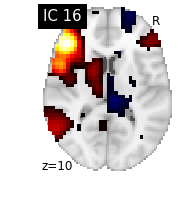

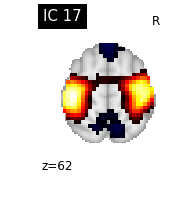

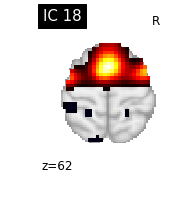

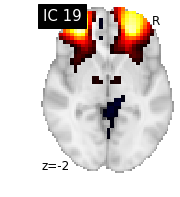

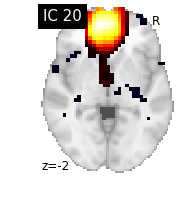

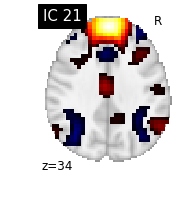

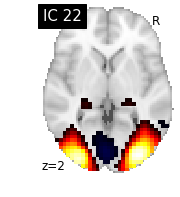

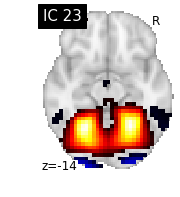

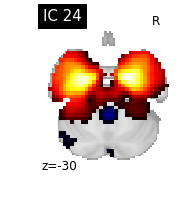

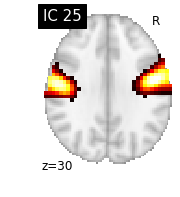

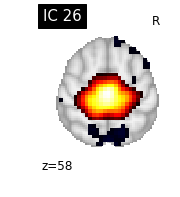

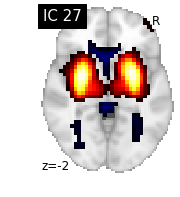

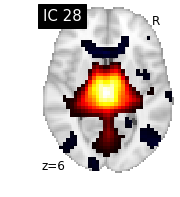

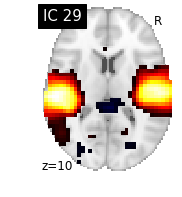

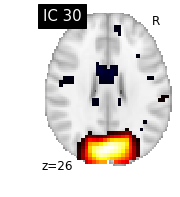

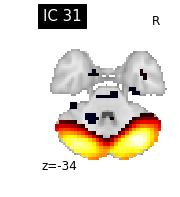

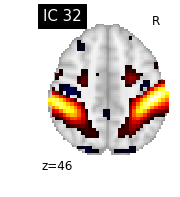

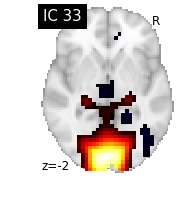

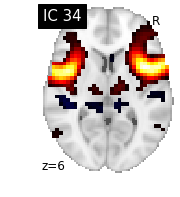

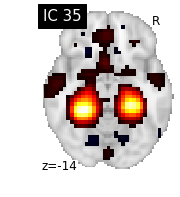

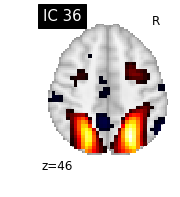

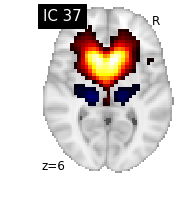

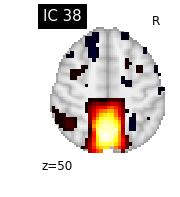

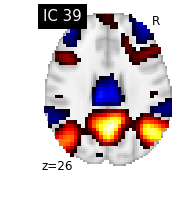

In [7]:
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

show()

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/isolve/iterative.py:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibil

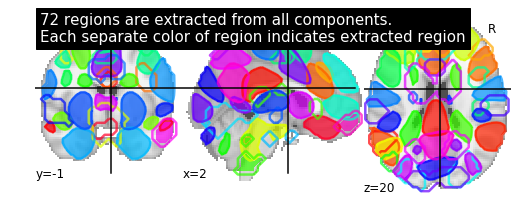

In [8]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=5000)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

from nilearn.plotting import plot_prob_atlas
# Visualization of region extraction results
title = ('%d regions are extracted from %s components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 'all'))
plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

In [9]:
import os
func_filenames=[]
for x in os.listdir('/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU'):
    file='/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/'+str(x)+'/sfnwmrda'+str(x)+'_session_1_rest_1.nii.gz'
    #print(file)
    if os.path.isfile(file):
        func_filenames.append(file)  
    else:
        print(file)  
func_filenames=sorted(func_filenames)
print(len(func_filenames))

adhd_labels=Y  # 1 if ADHD, 0 if control

# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure

adhd_time_series = []
all_time_series = []

# Initializing ConnectivityMeasure object with kind='correlation'
correlation_measure = ConnectivityMeasure(kind='correlation')
for filename,is_adhd in zip(func_filenames,adhd_labels):
    print(filename)
    time_series = extractor.transform(filename)   
    all_time_series.append(time_series)
    if is_adhd:
        adhd_time_series.append(time_series)      

/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/motion/sfnwmrdamotion_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/All_Labels.npy/sfnwmrdaAll_Labels.npy_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/All_Data.npy/sfnwmrdaAll_Data.npy_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/All_Data_20.npy/sfnwmrdaAll_Data_20.npy_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/NYU_phenotypic.csv/sfnwmrdaNYU_phenotypic.csv_session_1_rest_1.nii.gz
216
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010001/sfnwmrda0010001_session_1_rest_1.nii.gz


/home/uga_qinglin/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010002/sfnwmrda0010002_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010003/sfnwmrda0010003_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010004/sfnwmrda0010004_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010005/sfnwmrda0010005_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010006/sfnwmrda0010006_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010007/sfnwmrda0010007_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010008/sfnwmrda0010008_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010009/sfnwmrda0010009_session_1_rest_1.nii.gz
/home/share/TmpData/Qinglin/ADHD200_Athena_preproc_flirtfix/NYU/0010010/sfnwmrda0010010_session_1_rest_1

KeyboardInterrupt: 

In [ ]:
connectivity_biomarkers = {}

conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True)
connectivity_biomarkers = conn_measure.fit_transform(all_time_series)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers.shape[1]))


from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(n_splits=3)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

from sklearn.model_selection import cross_val_score
mean_scores = []

for name, clf in zip(names, classifiers):
    cv_scores = cross_val_score(clf,
                                connectivity_biomarkers,
                                y=adhd_labels,
                                cv=cv,
                                groups=adhd_labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

In [ ]:
from nilearn.plotting import show
import numpy as np
import matplotlib.pylab as plt
plt.figure(figsize=(6, 4))
positions = np.arange(len(names)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [name.replace(' ', '\n') for name in names]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()